In [1]:
import pandas as pd

In [2]:
%matplotlib inline
from matplotlib import pyplot  # plotting

In [3]:
# Import the data from csv files into Pandas DataFrames
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [4]:
# See what the data looks like
print(train.shape, 'train: first column contains true label, 28x28 image') 
print(test.shape, '28x28 image')

(42000, 785) train: first column contains true label, 28x28 image
(28000, 784) 28x28 image


In [5]:
train.iloc[:, 1:].shape

(42000, 784)

In [5]:
# Normalization
train.iloc[:, 1:] = train.iloc[:, 1:].apply(lambda x: x / 255)
test = test.apply(lambda x: x / 255)

In [7]:
train.iloc[41990:41992,150:160]

,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158
41990,0.14902,0.439216,0.631373,0.866667,0.996078,0.960784,0.631373,0.200000,0.000000,0.0
41991,0.00000,0.000000,0.000000,0.000000,0.513725,0.996078,0.996078,0.823529,0.011765,0.0


this digit is 3


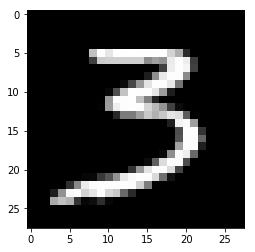

In [8]:
print("this digit is", train.iloc[25,0])
digit = train.iloc[25, 1:785].values.reshape(28,28)
pyplot.imshow(digit, cmap='gray')

In [9]:
# Get smaller subset
num_sample = 42000

train_small = train.iloc[:(num_sample-1000), :]
validation_small = train.iloc[(num_sample-1000):num_sample, :]

In [10]:
train_small.shape

(41000, 785)

In [11]:
validation_small.shape

(1000, 785)

In [6]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [7]:
print(torch.cuda.is_available())

False


In [18]:
# Hyper parameters
num_epochs = 5
hidden_size = 50
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [ ]:
train_image = train_small.iloc[:, 1:].values.reshape(-1, 1, 28, 28)
train_label = train_small.iloc[:, 0].values
print(train_image.shape)
print(train_label.shape)

In [15]:
t_image = torch.FloatTensor(train_image)
t_label = torch.LongTensor(train_label)
train_dataset = list(zip(t_image, t_label))
len(train_dataset)

41000

In [14]:
validation_image = validation_small.iloc[:, 1:].values.reshape(-1, 1, 28, 28)
validation_label = validation_small.iloc[:, 0].values
print(validation_image.shape)
print(validation_label.shape)

(1000, 1, 28, 28)
(1000,)


In [16]:
v_image = torch.FloatTensor(validation_image)
v_label = torch.LongTensor(validation_label)
validation_dataset = list(zip(v_image, v_label))
len(validation_dataset)

1000

In [29]:
test_image = test.values.reshape(-1, 1, 28, 28)
test_dataset = torch.FloatTensor(test_image)

In [19]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [59]:
len(test_dataset)

28000

In [60]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=len(test_dataset), 
                                          shuffle=False)

In [42]:
for images, labels in train_loader:
    print('images:', images.shape, '\nlabels:', labels.shape)
    print(images[1][0][6])
    print(labels[1])
    break

images: torch.Size([100, 1, 28, 28]) 
labels: torch.Size([100])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.1373,  0.9922,  0.9922,  0.6275,
         0.1569,  0.3882,  0.9922,  0.9922,  0.5882,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
tensor(2)


In [32]:
for images in test_loader:
    print('images:', images.shape)
    print(images[0][0][6])
    break

images: torch.Size([100, 1, 28, 28])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.2353,  0.8941,  0.9922,  0.9922,  0.9922,
         0.9922,  0.9922,  0.9922,  0.9922,  0.8118,  0.7725,  0.1804,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])


In [21]:
class PytorchDeepConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(PytorchDeepConvNet, self).__init__()

        # Layer 1: conv - relu - conv- relu - pool
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        # Layer 2: conv - relu - conv- relu - pool
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Fully Connected 1 (readout)
        self.fc1 = nn.Linear(32 * 7 * 7, num_classes)
        
        # Initialize all parameters using kaiming normalization
        self.init_weights_kaiming()
    
    def init_weights_kaiming(self):
        for layer in [self.layer1, self.layer2]:
            for m in layer:
                if type(m) == nn.Conv2d:
                    m.weight = nn.init.kaiming_normal_(m.weight)
        
        self.fc1.weight = nn.init.kaiming_normal_(self.fc1.weight)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0), -1)
    
        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [22]:
model = PytorchDeepConvNet(num_classes)
print(model)
criterion = nn.CrossEntropyLoss()
# Use Adam as the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

PytorchDeepConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


In [23]:
iter = 0
# accuracies = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = Variable(images) # Now we dont need to resize like images.view(xx)
        labels = Variable(labels)
        
        # Clear gradients w.r.t parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: Softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t paramters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 50 == 0:
            # Print Loss
            print('Iteration: {}. Loss: {}.'.format(iter, loss.item()))

Iteration: 50. Loss: 0.2688966393470764.
Iteration: 100. Loss: 0.19573372602462769.
Iteration: 150. Loss: 0.13630276918411255.
Iteration: 200. Loss: 0.06110623851418495.
Iteration: 250. Loss: 0.11940505355596542.
Iteration: 300. Loss: 0.08742796629667282.
Iteration: 350. Loss: 0.0591735802590847.
Iteration: 400. Loss: 0.023604927584528923.
Iteration: 450. Loss: 0.036535002291202545.
Iteration: 500. Loss: 0.03368818014860153.
Iteration: 550. Loss: 0.0860200896859169.
Iteration: 600. Loss: 0.03653855249285698.
Iteration: 650. Loss: 0.12522092461585999.
Iteration: 700. Loss: 0.01993611454963684.
Iteration: 750. Loss: 0.04363555461168289.
Iteration: 800. Loss: 0.07630090415477753.
Iteration: 850. Loss: 0.026916280388832092.
Iteration: 900. Loss: 0.032773490995168686.
Iteration: 950. Loss: 0.1278548240661621.
Iteration: 1000. Loss: 0.029393989592790604.
Iteration: 1050. Loss: 0.04361877962946892.
Iteration: 1100. Loss: 0.010259303264319897.
Iteration: 1150. Loss: 0.08307251334190369.
Iterat

In [24]:
wrong_predictions = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in validation_loader:
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # See which are error predictions
        result = (predicted == labels)
        err_imgs = images[result == 0] # 0 means wrong prediction
        err_labels = labels[result == 0]
        err_outputs = predicted[result == 0]
        for img, lbl, out in zip(err_imgs, err_labels, err_outputs):
            wrong_predictions.append((img, lbl, out))
     
    print('Test Accuracy of the model on the 1000 validation images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 validation images: 98.6 %


In [61]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images in test_loader:
        images = Variable(images)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  

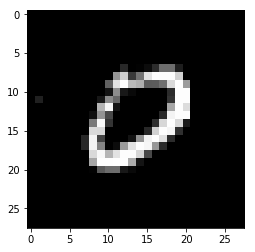

In [62]:
pyplot.imshow(images[3].reshape(28,28), cmap='gray')

In [63]:
predicted[3]

tensor(0)

In [64]:
predicted.shape

torch.Size([28000])

In [81]:
predicted.shape[0]

28000

In [105]:
result = pd.DataFrame({'Label': predicted.numpy(), 'ImageId': list(range(1, predicted.shape[0] + 1))})
result.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [106]:
result.to_csv('prediction.csv',index=False)